In [15]:
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import matplotlib.image as mpimg

### Validate Data Path

In [16]:
cwd = os.getcwd()

## Place the data in Food-11 directory
data_in_dir = os.path.join(cwd, "Food-11")
assert(os.path.isdir(data_in_dir))

subdirs = {
    'train' : 'training',
    'valid' : 'validation',
    'eval'  : 'evaluation'}
dirs = os.listdir(data_in_dir)

## Validate we have these 3 subdirectories
assert(len(dirs) == len(subdirs) and sorted(dirs) == sorted(subdirs.values()))
   
## Validate that we have the sored data from EDA in pickle format
pickle_dir = os.path.join(cwd, "food-classification-pickle_data")
assert(os.path.isdir(pickle_dir))
data_files = os.listdir(pickle_dir)
data_files
datastore_files = {
    'train' : 'training.pickle',
    'valid' : 'validation.pickle',
    'eval'  : 'evaluation.pickle'}
## Validate we have these 3 datafiles
assert(len(data_files) == len(datastore_files) and sorted(data_files) == sorted(datastore_files.values()))

### Read data from pickle file to dataframes

In [17]:
train_data = pd.read_pickle(os.path.join(pickle_dir, datastore_files['train']))
val_data = pd.read_pickle(os.path.join(pickle_dir, datastore_files['valid']))
eval_data = pd.read_pickle(os.path.join(pickle_dir, datastore_files['eval']))

In [18]:
print(train_data.shape)
print(val_data.shape)
print(eval_data.shape)

(9866, 2)
(3430, 2)
(3347, 2)


### One Hot Encoding Helper Function

In [19]:
MAX_LABELS = len(train_data.Label.unique())

def onehotencoder(label_out):
    batch_size = len(label_out)
    encoded = np.zeros((batch_size, MAX_LABELS))
    encoded[np.arange(batch_size), label_out] = 1
    return encoded

##  Define GET Batch Helper Function

In [20]:
def getbatch(data_in, batchsize=32):
    arraylength = len (data_in);
    count = 0 
    while count < arraylength/batchsize:
        randindex = random.sample(range(0, arraylength), batchsize)
        count += 1
        image_path_out = [data_in.Path[i] for i in randindex]
        label_out = [data_in.Label[i] for i in randindex]
        one_hot_encoded_label_out = onehotencoder(label_out)
        yield (image_path_out, one_hot_encoded_label_out)

## --Augment Data NEGATIVE Helper Function¶

https://hackernoon.com/how-tensorflows-tf-image-resize-stole-60-days-of-my-life-aba5eb093f35

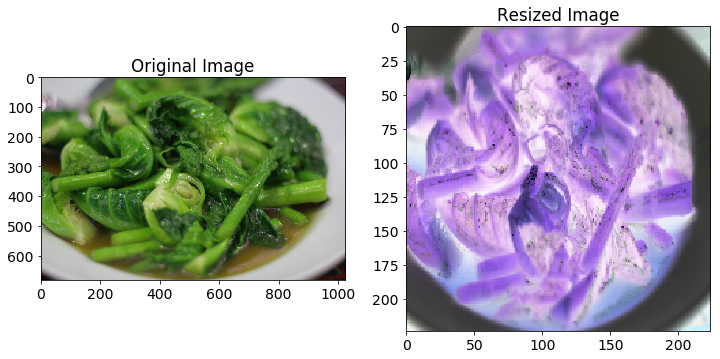

In [21]:
import matplotlib
import matplotlib.pyplot as plt
IMAGE_SIZE = 224

def tf_resize_images(X_img_file_paths, size=IMAGE_SIZE):
    X_data = []
    #tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (size, size), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

X_img_paths, Y_Labels = next(getbatch(train_data))
X_imgs = tf_resize_images(X_img_paths)

matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(X_img_paths[4])[:,:,:3])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_imgs[4])
plt.title('Resized Image')
plt.show()

In [18]:
x, y = next(getbatch(train_data))
a = tf_resize_images(x)


## Dump the dataframe to file to feed it into Alexnet

In [22]:
train_data.to_csv("train.txt", sep=" ", header=False, index=False)
val_data.to_csv("valid.txt", sep=" ", header=False, index=False)
eval_data.to_csv("eval.txt", sep=" ", header=False, index=False)

### Alexnet Training

## Define and Setup  Hyper-Parameters

## Initialize TensorBoard

## Defining Input Placeholders

## Define Model

## Define Model Saver

## Initializing Weights and Biases

## Define Cost, Optimizer and Accuracy

## Start Training

In [7]:
## Save the session after every epoch or 1000 runs

## Retrive Saved Session And Validate